---
title: "Facebook Prophet, Covid and why I don't trust the Prophet"
author: "Sarem"
date: "2022-08-08"
categories: [Time Series]
format:
  html:
    toc: true
    toc-location: left
    toc-depth: 2
    toc-title: Contents
description-meta: "Facebook Prophet is highly popular for time-series forecasting. Let me show you why I am not a big fan and what else you can use."
---

## Introduction

Facebook Prophet is arguably one of the most widely known tools for time-series forecasting and related tasks. Ask any data scientist who works with time-series data if they know Prophet and the answer is likely either a yes or an annoyed yes.

After all, Facebook Prophet has become quite a controversial tool for time-series problems. Some people don't want to work without it anymore, [others clearly hate it](https://medium.com/@valeman/benchmarking-facebook-prophet-53273c3ee9c6?ref=sarem-seitz.com).

However, whether you like it or not, [Prophet users seem to face considerable challenges when it comes to modelling the Covid-19 shock](https://github.com/facebook/prophet/issues/1416?ref=sarem-seitz.com). While, by now, people have found workaround, I'd argue that these issues are caused by a deeper problem with Facebook Prophet:

## The fundamental flaw of Facebook Prophet
The most problematic aspect of Facebook Prophet is that it reduces time-series modelling to a curve-fitting task. Other approaches make auto-regressive dynamics a fundamental assumption. Prophet, on the other hand, merely tries to draw a least-error line through time against your data.

More technically, the evolution of almost all dynamical systems depend on past realizations. We can write this as follows:
$$
p\left(y_t, y_{t-1}, \ldots, y_1\right)=p\left(y_t \mid y_{t-1}\right) p\left(y_{t-1} \mid y_{t-2}\right) \cdots p\left(y_1\right)
$$
Where we only consider dependence on the last observation and no hidden states.

Most time-series models focus on the right-hand side. Facebook Prophet, however, is concerned with the left-hand side of the equation. Even worse, Prophet implicitly makes the following assumptions on top (see [Facebook Prophet paper](https://peerj.com/preprints/3190/?ref=sarem-seitz.com), page 14, for reference):
$$
\begin{gathered}
p\left(y_t, y_{t-1}, \ldots, y_t\right) \\
=\mathcal{N}\left(y_t \mid m(t), \sigma^2\right) \cdot \mathcal{N}\left(y_{t-1} \mid m(t-1), \sigma^2\right) \cdots \mathcal{N}\left(y_1 \mid m(1), \sigma^2\right)
\end{gathered}
$$
This is problematic for at least three reasons:

1. **Dependence on past realizations is completely ignored**. In the real-world, a single, large shock will quickly change the whole future trajectory of the time-series. This can trivially be accounted for by a dynamical model but not by Facebook Prophet.
2. **The mean function needs to extrapolate outside the range of observed values**. The way that Prophet frames the modelling problem inevitably leads to the problem of out-of-distribution generalization. All your future t's will lie outside your training domain by design.
3. **Variance is presumed to be constant**. Related to 1. - if random shocks have impact on the future, variance - as a measure of uncertainty - should grow as we are forecasting further ahead.

As a general rule of thumb: If the forecast intervals of your model do not grow over time, something is likely wrong with it. Unless you know exactly what you are doing, you should consider an alternative.

## Facebook Prophet underperforms against a toy benchmark
To exemplify the above, I ran a pretty simple forecasting benchmark on German economic data. While the example is a little artificial and too small to generalize, the implications should be clear.

I used the following dataset: Retail sale in non-specialised stores (ex. food) - Jan 2012 - May 2022 (monthly; available [here]). The train set consists of all data from Jan 2021 to Dec 2019; the test set uses all data from Jan 2020 - May 2022:

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/var/folders/2d/hl2cr85d2pb2kfbmsng3267c0000gn/T/ipykernel_63305/4068186796.py:9: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pd.concat([pd.Series(pd.date_range(date(2012,1,1),date(2022,6,1),freq="M")),ts.reset_index(drop=True)],1)


Text(0.5, 1.0, 'Germany, Retail sale in non-specialised stores (ex. food) - Jan 2012 - May 2022')

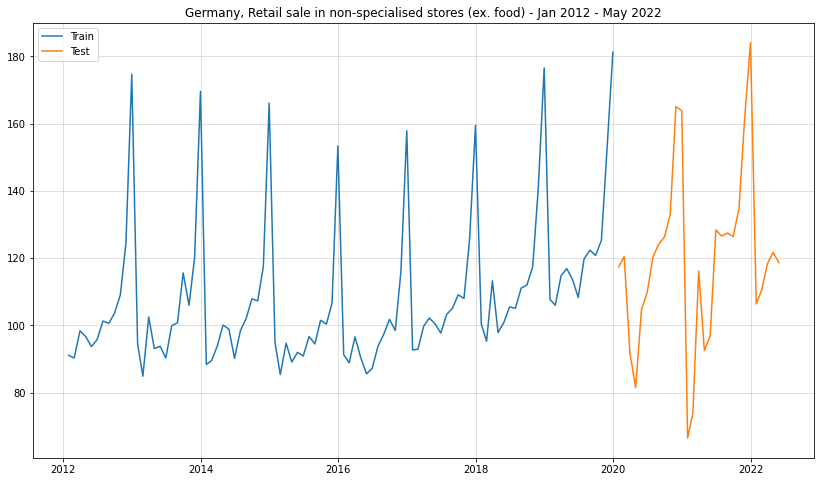

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date


df = pd.read_excel("../data/45212-0004.xlsx")
ts = df.iloc[804:937,2].replace("...",np.nan).dropna()
df = pd.concat([pd.Series(pd.date_range(date(2012,1,1),date(2022,6,1),freq="M")),ts.reset_index(drop=True)],1)
df.columns = ["ds","y"]
df.index = df["ds"]

df_train = df.iloc[:96,:]
df_test = df.iloc[96:,:]

plt.figure(figsize = (14,8))
plt.plot(df_train["y"], label = "Train")
plt.plot(df_test["y"], label = "Test")
plt.grid(alpha = 0.5)
plt.legend()
plt.title("Germany, Retail sale in non-specialised stores (ex. food) - Jan 2012 - May 2022")

A reasonable forecasting model should be able to anticipate at least the possibility of random shocks. This would usually be visible by increasing forecast intervals. After all, the further we look ahead, the more opportunities for high impact events.

In this case, the time-series does not go completely bonkers after the shock from Corona. Thus, Facebook Prophet should not struggle too much here. Let's see how it does:

### A simple Prophet forecast

18:21:49 - cmdstanpy - INFO - Chain [1] start processing
18:21:50 - cmdstanpy - INFO - Chain [1] done processing


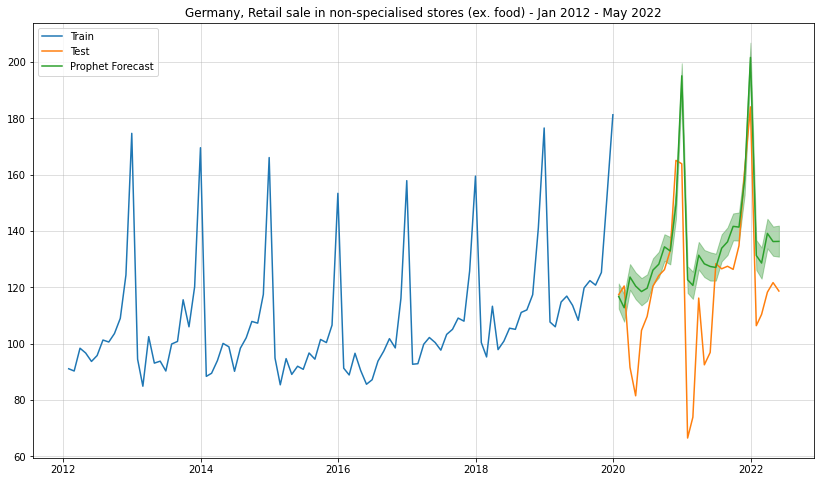

In [4]:
from prophet import Prophet

m = Prophet()
m.fit(df_train)

prph_pred = m.predict(df_test)

plt.figure(figsize = (14,8))
plt.plot(df_train["y"], label = "Train")
plt.plot(df_test["y"], label = "Test")
plt.grid(alpha = 0.5)
plt.title("Germany, Retail sale in non-specialised stores (ex. food) - Jan 2012 - May 2022")

plt.plot(df_test.index,prph_pred["yhat"],label = "Prophet Forecast")
plt.fill_between(df_test.index,prph_pred["yhat_lower"],prph_pred["yhat_upper"],alpha=0.3,color="green")

plt.legend()

For the mean forecast Prophet was able to reasonably predict out-of-sample - at least to some extent. The forecast intervals, however, are completely ludicrous. Our model simply took roughly the residuals from the in-sample data and projected their intervals into the future.

This clearly shows that Facebook Prophet did not really learn the inherent dynamics but merely a function of time. If the impact of Covid on the underlying dynamics were worse, we would likely not even see reasonable point forecasts either. I am sure that there are many data scientists out there where this was exactly the case.

### An even simpler forecast model
As you might have heard by now, Prophet does not learn anything about the underlying system dynamics. Thus, our goal is to now create a competitor that is **a)** very simple and **b)** capable of actually modelling the dynamics.

From the time-series plot, we see that there is a clear yearly seasonality. After removing that via [seasonal differencing](https://faculty.fuqua.duke.edu/~rnau/Decision411_2007/Class10notes.htm?ref=sarem-seitz.com), I saw that there was a [remaining integration component](https://en.wikipedia.org/wiki/Order_of_integration?ref=sarem-seitz.com#:~:text=A%20time%20series%20is%20integrated,times%20yields%20a%20stationary%20process.) that I removed via another round of first-order differencing.

Obviously, this is not a full diagnostic but sufficient for our simple toy example. Also, since the time-series is non-negative, I initially transformed it by taking the square-root. This ensures that the re-transformed series will be non-negative as well.

All the above leads us to the following, relatively simple model:
$$
\Delta \Delta_{12} \sqrt{y_t} \sim p(\epsilon)
$$
In summary, we assume that, after 'square-rooting' and differencing, only a noise term remains. Here, we even assume that the noise distribution stays constant over time. A more sophisticated model should obviously check for time-varying noise.

The only thing that our model now needs to learn is the distribution of the noise. Afterwards, we draw noise samples and re-integrate (i.e. re-transform the differencing operations). Finally, we estimate point and interval forecasts.

To learn the noise distribution, I used scipy's `gaussian_kde` function. This fits a [Gaussian kernel density](https://en.wikipedia.org/wiki/Kernel_density_estimation?ref=sarem-seitz.com) estimator to the data. We can then use this estimate to draw noise samples:

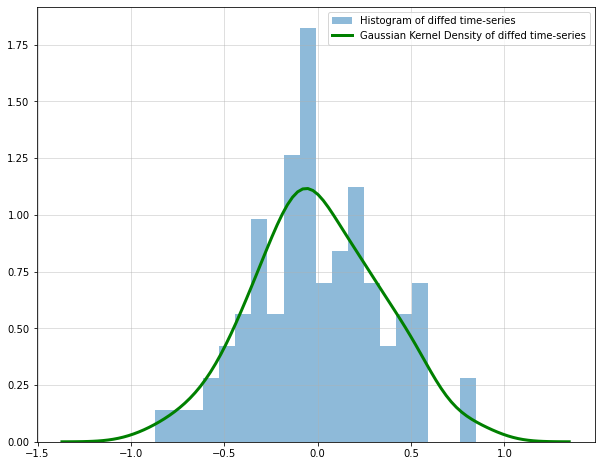

In [6]:
from scipy.stats import gaussian_kde

#reverting the order of differencing yields the same result but makes re-transformation easier
diffed = np.sqrt(df_train["y"]).diff().dropna()
diffed_s = diffed.diff(12).dropna()

plt.figure(figsize = (10,8))
plt.grid(alpha = 0.5)
plt.hist(diffed_s,bins=20,density = True,alpha=0.5, label = "Histogram of diffed time-series")

kde = gaussian_kde(diffed_s)

target_range = np.linspace(np.min(diffed_s)-0.5,np.max(diffed_s)+0.5,num=100)

plt.plot(target_range, kde.pdf(target_range),color="green",lw=3, label = "Gaussian Kernel Density of diffed time-series")

plt.legend()

Next, we draw samples and re-transform them into a forecast of our original time-series:

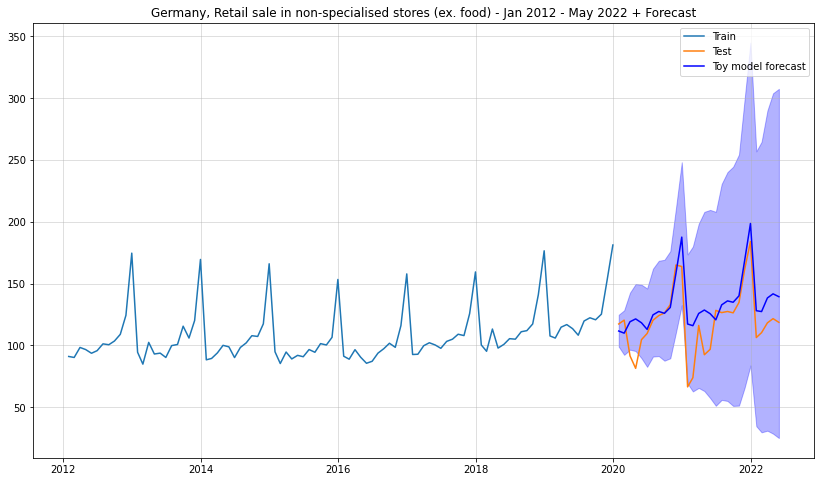

In [7]:
np.random.seed(321)

full_sample = [] 

for i in range(10000):
    draw = kde.resample(len(df_test)).reshape(-1)
    result = list(diffed.iloc[-12:].values)

    for t in range(len(df_test)):
        result.append(result[t]+draw[t])

    full_sample.append(np.array((np.sqrt(df_train.iloc[-1]["y"])+np.cumsum(result[12:]))).reshape(-1,1)**2)


reshaped = np.concatenate(full_sample,1)
result_mean = np.mean(reshaped,1)
lower = np.quantile(reshaped,0.05,1)
upper = np.quantile(reshaped,0.95,1)

plt.figure(figsize = (14,8))
plt.plot(df_train["y"], label = "Train")
plt.plot(df_test["y"], label = "Test")
plt.grid(alpha = 0.5)
plt.title("Germany, Retail sale in non-specialised stores (ex. food) - Jan 2012 - May 2022 + Forecast")

plt.plot(df_test.index, result_mean,label = "Toy model forecast",color="blue")
plt.fill_between(df_test.index,lower,upper,alpha=0.3,color="blue")


plt.legend()

Especially the forecast interval makes much more sense than for Facebook Prophet. As desired, the forecast intervals grow larger over time which implies increasing uncertainty.

Let us also do a side-by-side comparison:

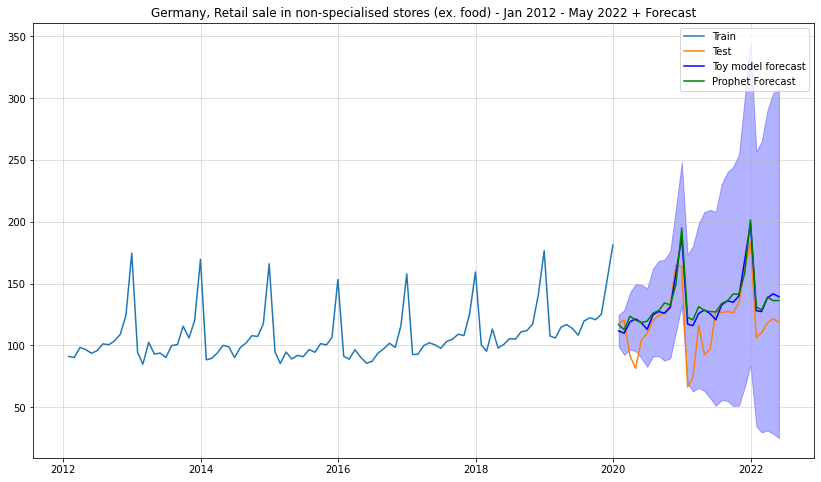

In [11]:
plt.figure(figsize = (14,8))
plt.plot(df_train["y"], label = "Train")
plt.plot(df_test["y"], label = "Test")
plt.grid(alpha = 0.5)
plt.title("Germany, Retail sale in non-specialised stores (ex. food) - Jan 2012 - May 2022 + Forecast")

plt.plot(df_test.index, result_mean,label = "Toy model forecast",color="blue")
plt.fill_between(df_test.index,lower,upper,alpha=0.3,color="blue")

plt.plot(df_test.index,prph_pred["yhat"],label = "Prophet Forecast",color="green")

plt.legend()

We can also calculate the RMSE for both mean forecasts:

In [14]:
rmse_simple = np.sqrt(np.mean((result_mean-df_test["y"].values)**2))
rmse_prophet = np.sqrt(np.mean((prph_pred["yhat"].values[-len(df_test):]-df_test["y"].values)**2))

print("Simple Model: {}".format(rmse_simple))
print("Prophet: {}".format(rmse_prophet))

Simple Model: 20.745456460849358
Prophet: 22.49447614293072


## Takeaways for the dedicated Prophet user
The question is, what do we make out of this? Clearly, the large, long-term user-base of Facebook Prophet indicates that people are getting some value from it. Also, Facebook/Meta employs some very bright people - it's highly unlikely that they would produce a completely useless library.

Going back to our initial considerations, we can deduce the following:

Prophet should work fine as long as it correctly depicts the conditional mean and the conditional variance. Mathematically,

$$
\begin{gathered}
m_{\text {prophet }}(t+h) \approx \mathbb{E}\left[y_{t+h} \mid y_t, \ldots, y_1\right] \\
v_{\text {prophet }}(t+h)=\sigma^2 \approx \mathbb{V} \operatorname{Vr}\left[y_{t+h} \mid y_t, \ldots, y_1\right]
\end{gathered}
$$
for all forecast periods $t+h$.

This could be the case when the underlying system is in a nice, equilibrium, e.g. when the economy is in a non-volatile state. However, as soon as there is a large shock, the variance requirement is almost certain to be broken. This is exactly what we saw in the example time-series above.

Thus, should you drop Prophet altogether? If the results are good **and** if your forecasts going completely nuts does not have a large negative impact, I'd argue that you should keep it. Never change a running system, at least not over night.

If you are heavily dependent on a model that can randomly break at any time, though, you might want to start looking for alternatives.

Another use-case where Facebook Prophet makes more sense in my opinion, is outlier and change point detection. If you are simply interested in deviations from the expected trajectory, prophet can score you some quick and easy wins. As soon as forecast quality becomes a thing, however, you should be careful.

Will [Neural Prophet], a.k.a. Facebook Prophet 2.0, make things better? At least their Deep-AR module now considers past realizations to predict the future. On the other hand, Neural Prophet still makes heavy use of curve fitting. Thus, you should be wary of the Prophet upgrade, too.

If you decide that you are going to use either of the Prophets, I recommend  benchmarking against trivial alternatives. When a simple but theoretically more sound model - as in our example - performs comparably, you might want to reconsider your choice.

## Alternatives to Facebook Prophet
No mini-rant without trying to offer a solution. On the one hand, these alternatives will require more manual work to find a suitable model. On the other hand, chances are good that the product will be more robust than a convenient Prophet().fit().

- [Kats](https://facebookresearch.github.io/Kats/?ref=sarem-seitz.com): While Kats is a broad library for general time-series analysis, it offers some endpoints for forecasting as well. Just like Prophet, it has also been open sources by Facebook/Meta.
- [Darts](https://unit8co.github.io/darts/?ref=sarem-seitz.com#): Specifically aimed at forecasting problems. Darts provides support for a variety of modelling options.
- [tsfresh](https://tsfresh.readthedocs.io/en/latest/?ref=sarem-seitz.com#): This package only creates a large set of time-series summary statistics for you. Then, you can use those features as predictors in a custom forecasting model. Pretty flexible, but also more manual work.

## Conclusion
Despite its popularity, Facebook Prophet contains some serious theoretical issues. These flaws can easily render its forecasts useless. On the one hand, Prophet makes building forecast models at scale more or less a breeze. This convenience, however, comes at the cost of a fair amount of unreliability.

To summarize all the above: As long as you expect your time-series to remain somewhat stable, Prophet can be a helpful plug-and-play solution. However, don't get fooled by Prophet being right many times. Worst case, you ultimately go bust when it suddenly isn't anymore.